In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [2]:
%matplotlib inline

In [3]:
#fly = flb.NetFly(1525,rootpath='/media/imager/FlyDataD/FlyDB/')
#fly.open_signals()

In [4]:
flynumbers = list(range(1389,1402))

In [5]:
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]

In [6]:
#l = [fly.open_signals() for fly in flylist]

In [7]:
fly = flylist[4]
fly.open_signals()

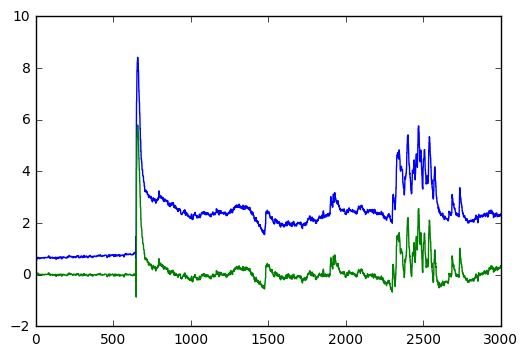

In [8]:
plt.plot(fly.ca_cam_left_model_fits['hg1'][:3000])
plt.plot(fly.ca_cam_left_model_fits['hg1'][:3000] - 
         scipy.signal.medfilt(fly.ca_cam_left_model_fits['hg1'][:3000],501))
#plt.plot(fly.ca_cam_left_model_fits['b2'])

In [9]:
def condition_signal(sig_name,signal):
    """do some data cleaning on the signals.
    For instnace the transients from b2 are week
    so I need to detrend in order to remove the
    contaminating baseline"""
    if sig_name == 'b2':
        return signal - scipy.signal.medfilt(signal,501)
    if sig_name == 'iii1':
        return signal - scipy.signal.medfilt(signal,501)
    if sig_name == 'hg1':
        return signal - scipy.signal.medfilt(signal,501)
    return signal

In [10]:
resample_rate = 2000 #hz

In [11]:
resampled_left = {}
for key,value in fly.ca_cam_left_model_fits.items():
    value = condition_signal(key,value)
    resampled_ca,resampled_t = scipy.signal.resample(value,
                                           int(fly.time[-1]*2000),np.array(fly.time),
                                            window = 'hanning')
    resampled_left[key] = resampled_ca

resampled_right = {}
for key,value in fly.ca_cam_right_model_fits.items():
    value = condition_signal(key,value)
    resampled_ca,resampled_t = scipy.signal.resample(value,
                                           int(fly.time[-1]*2000),np.array(fly.time),
                                            window = 'hanning')
    resampled_right[key] = resampled_ca

In [12]:
resampled_freq,resampled_t = scipy.signal.resample(fly.wb_freq,
                                 int(fly.time[-1]*2000),
                                 np.array(fly.time),
                                 window = 'hanning')

In [13]:
def get_potential_idxs(resampled_freq,resampled_t):
    potential_impulse_idxs = list()
    spike_idx = 1
    spike_time = resampled_t[spike_idx]
    while(spike_time<resampled_t[-1]):
        spike_idx = np.searchsorted(resampled_t,spike_time)
        potential_impulse_idxs.append(spike_idx)
        isi = 1./resampled_freq[spike_idx]
        if (abs(isi) < 0.02):
            spike_time += isi[0]
        else:
            spike_time += 0.005
    return potential_impulse_idxs

In [14]:
#%load_ext line_profiler

In [15]:
#%lprun -f get_potential_idxs get_potential_idxs(resampled_freq=resampled_freq,resampled_t=resampled_t)

In [16]:
#%lprun -f get_potential_idxs get_potential_idxs(resampled_freq=resampled_freq,resampled_t=resampled_t)

In [17]:
potential_impulse_idxs = get_potential_idxs(resampled_freq,resampled_t)

In [18]:
kernel = lpf.make_single_kernel(resampled_t,0.01595905,0.23594343)

local_project_functions.py:13: RuntimeWarning: divide by zero encountered in divide
  kon1 = lambda x:np.exp(((-1*tauon1)/(x)))


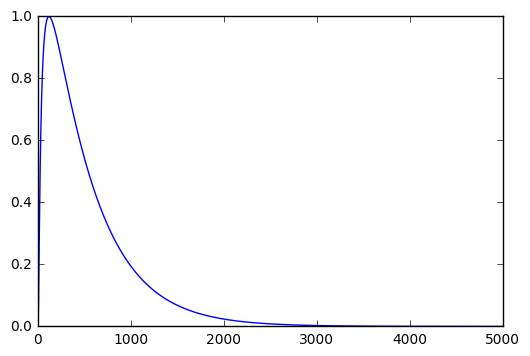

In [19]:
plt.plot(kernel[:5000])

In [20]:
decon_left = {}
for key,value in resampled_left.items():
    decon = lpf.wiener_deconvolution(value,kernel[:5000]*0.4,1.0)
    decon_left[key] = decon

decon_right = {}
for key,value in resampled_right.items():
    decon = lpf.wiener_deconvolution(value,kernel[:5000]*0.4,1.0)
    decon_right[key] = decon

In [21]:
#thresh = 0.06
spikes_left = {}
for key,value in decon_left.items():
    print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_left[key])[0][1],
                           impulses,
                           recon))
    spikes_left[key] = threshlist
    
spikes_right = {}
for key,value in decon_right.items():
    print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_right[key])[0][1],
                          impulses,
                          recon))
    spikes_right[key] = threshlist
    
#spikes_right = {}
#for key,value in decon_right.items():
#    thresh = np.percentile(value,50)
#    impulses = np.zeros_like(value)
#    impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
#    spikes_right[key] = impulses

pr
tpd
nm
iii1
iii3
i2
hg2
hg3
hg1
i1
bkg
b1
b2
b3
iii24
hg4
pr
tpd
nm
iii1
iii3
i2
hg2
hg3
hg1
i1
bkg
b1
b2
b3
iii24
hg4


In [22]:
best_spikes = {}
for key,value in spikes_left.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['left',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}
for key,value in spikes_right.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['right',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}

In [23]:
#fly.save_hdf5(np.array(potential_impulse_idxs),'potential_impulse_idxs',overwrite = True)

#for key1,value1 in best_spikes.items():
#    for key2,data in value.items():
#        if key2 == 'R':
#            fly.save_txt(str(data),'spikes_%s_%s_%s'%(key1[0],key1[1],key2))
#        else:
#            fly.save_hdf5(data,'spikes_%s_%s_%s'%(key1[0],key1[1],key2),overwrite = True)

In [28]:
potential_impulse_times = resampled_t[potential_impulse_idxs]

In [53]:
for key in best_spikes:    
    spike_sig = best_spikes[key]['spikes']
    state_sig = np.zeros_like(fly.time)
    for i,timetup in enumerate(zip(fly.time[:-1],fly.time[1:])):
        t1,t2 = timetup
        idx1 = np.searchsorted(potential_impulse_times,t1)
        idx2 = np.searchsorted(potential_impulse_times,t2)
        state_sig[i] = np.sum(spike_sig[potential_impulse_idxs[idx1:idx2]]/(idx2-idx1))>0.5
    fly.save_hdf5(state_sig,'spikestate_%s_%s'%key, overwrite = True)

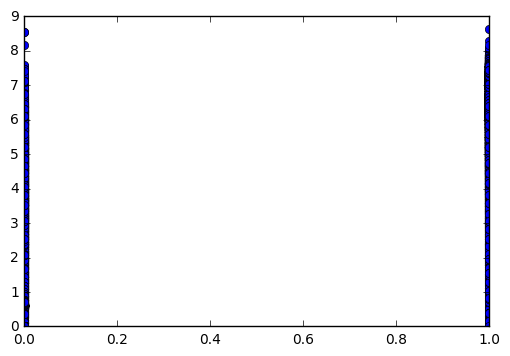

In [52]:
#plt.plot(state_sig)
plt.plot(state_sig,fly.ca_cam_right_model_fits['iii3'],'o')
#plt.gca().set_xbound(2800,6500)

In [50]:
fly.__dict__

{'abfpaths': [],
 'age': ['5 days, 14:43:16.993798'],
 'arena_cam_1': <HDF5 dataset "arena_cam_1": shape (47800, 103701), type "<f8">,
 'bagpaths': ['/media/imager/FlyDataD/FlyDB//Fly1393/_2017-10-16-14-43-16.bag'],
 'block_data': {('common',
   'idx',
   'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'): array([[ 7983,  7984,  7985, ...,  8375,  8376,  8377],
         [14739, 14740, 14741, ..., 15131, 15132, 15133],
         [21495, 21496, 21497, ..., 21887, 21888, 21889],
         [26449, 26450, 26451, ..., 26841, 26842, 26843],
         [35908, 35909, 35910, ..., 36300, 36301, 36302],
         [40863, 40864, 40865, ..., 41255, 41256, 41257]]),
  ('common',
   'idx',
   'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'): array([[ 4380,  4381,  4382, ...,  4772,  4773,  4774],
         [ 8433,  8434,  8435, ...,  8825,  8826,  8827],
         [20143, 20144, 20145, ..., 20535, 20536, 20537],
         [24197, 24198, 24199, ..., 24589, 24590, 24591],
         [36358, 36359, 36360, ..., 36750, 36751, 367